<a href="https://colab.research.google.com/github/AnkitaSavaliya/AIH/blob/main/MIMIC-III_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Github Link : https://github.com/AnkitaSavaliya/AIH/blob/main/MIMIC-III_NLP.ipynb

In [ ]:
import pandas as pd
from google.cloud import bigquery

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Fetching and Filtering Data of noteevents

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!gcloud projects list

from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(project='clinical-entity-extraction')

"""
ICD codes related to Hypertension:
 4010 - Malignant essential hypertension
 4011 - Benign essential hypertension
 4019 - Unspecified essential hypertension
"""
# Fetch notes only for ICD-9 code 4010(Malignant essential hypertension)
query = """
   SELECT SUBJECT_ID, TEXT, CATEGORY
    FROM `physionet-data.mimiciii_notes.noteevents`
    WHERE SUBJECT_ID IN (
        SELECT d.SUBJECT_ID
        FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
        WHERE d.ICD9_CODE = '4010' -- Hypertension code
        AND d.SEQ_NUM = 1  -- Assuming 1 indicates primary diagnosis
    )
    AND CATEGORY LIKE 'Discharge summary';
"""

# Run the query
query_job = client.query(query)

# Print the results
noteevents_df = query_job.to_dataframe()

len(noteevents_df)

Authenticated
PROJECT_ID                  NAME                        PROJECT_NUMBER
clinical-entity-extraction  clinical-entity-extraction  321960627270


162

In [ ]:
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[]};
for i in range(0, len(noteevents_df)):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])

In [ ]:
patients_df = pd.DataFrame(patients_dict)
len(patients_df)
patients_df = patients_df.iloc[2:] # Cleanup
#patients_df = patients_df.iloc[1:] #Cleanup

In [ ]:
#print first few records
patients_df.head(1)

,SUBJECT_ID,CATEGORY,TEXT
2,109,Discharge summary,Admission Date: [**2140-1-19**] ...


In [ ]:
# Download the patients_df dataframe in .csv and excel format
patients_df.to_csv(r'Patient_Summary.csv', index = False)
patients_df.to_excel("Patient_Summary.xlsx")

In [ ]:
# Copy Processed data to google drive
!cp 'Patient_Summary.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary.csv'
!cp 'Patient_Summary.xlsx' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary.xlsx'

### Functions to clean text and extract tokens and entities.

In [ ]:
! pip install -U spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.4 which is incompatible.


In [ ]:
! python -m spacy download en_core_web_sm

2025-02-13 21:02:59.719284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739480579.740664   20463 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739480579.747289   20463 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy

# Function to clean and extract tokens (removing punctuation and spaces)
def extract_cleaned_text(text, nlp_model):
    doc = nlp_model(str(text))  # Convert to string and process text
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    return " ".join(tokens)  # Return cleaned text as a string

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, words, preTrained=False):
    """
    Creates and displays two t-SNE plots:
    1. Simple scatter plot with labels.
    2. Scatter plot with distance-based coloring.

    Parameters:
    - model: The Word2Vec model or pre-trained model.
    - words: List of words to visualize.
    - preTrained: Boolean flag to choose between Word2Vec or pre-trained model.
    """
    labels = []
    tokens = []

    # Apply t-SNE for dimensionality reduction
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=1000, random_state=23)

    # Prepare tokens and labels
    for word in words:
        if preTrained:
            tokens.append(model[word])  # Pre-trained word vectors
        else:
            tokens.append(model.wv[word])  # Word2Vec model vectors
        labels.append(word)

    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)

    x = new_values[:, 0]
    y = new_values[:, 1]

    # First plot: Scatter plot with annotations
    plt.figure(figsize=(10, 8))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("t-SNE Visualization (Labels)")
    plt.show()

    # Second plot: Scatter plot with distance-based coloring
    plt.figure(figsize=(10, 8))
    distances = np.sqrt(new_values[:, 0]**2 + new_values[:, 1]**2)
    plt.scatter(new_values[:, 0], new_values[:, 1], c=distances, cmap='plasma')
    plt.colorbar(label="Distance from Origin")
    plt.title("t-SNE Visualization with Distance-Based Coloring")
    plt.show()

In [ ]:
import spacy

def build_corpus(df, model="en_core_web_sm"):
    """
    Extracts named entities from the specified text column in a DataFrame using a spaCy model,
    builds a corpus.

    Parameters:
    - df (pd.DataFrame): DataFrame containing text data.
    - text_column (str): Column name containing processed text.
    - model (str): spaCy model to use (default: "en_core_web_sm").

    Returns:
    - corpus (list of lists): Extracted entities per document.
    """
    nlp = model
    corpus = []

    for _, row in df.iterrows():
        tokens = [ent.text for ent in nlp(row["Processed_Text"]).ents]
        corpus.append(tokens)

    # Calculate word counts
    word_counts = [len(doc) for doc in corpus]

    print(f"Minimum word count: {min(word_counts)}, Maximum word count: {max(word_counts)}, Median word count: {sorted(word_counts)[len(word_counts) // 2]}")

    return corpus

## Using Spacy

In [ ]:
import pandas as pd

#Load Patient summary
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary.csv")

# Load the spacy model
nlp_spacy = spacy.load('en_core_web_sm')

# Apply token extraction
patients_df_scapy["Processed_Text"] = patients_df_scapy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_spacy))

#Copy Processed data to google drive
patients_df_scapy.to_csv(r'Patient_Summary_Spacy.csv', index = False)
!cp 'Patient_Summary_Spacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_Spacy.csv'

In [ ]:
import pandas as pd
# Load the processed patient data with spacy
patients_df_scapy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_Spacy.csv")

nlp_spacy = spacy.load('en_core_web_sm')  # Load the specified NLP model

In [ ]:
doc = nlp_spacy( patients_df_scapy['Processed_Text'][0])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

2297 146 150 DATE
Known 257 262 PERSON
22 year old 277 288 DATE
ESRD 321 325 ORG
TTP 350 353 ORG
HOCM 358 362 ORG
HA 381 383 ORG
Awoke 409 414 ORG
this a.m. 415 424 TIME
8/10 430 434 CARDINAL
HA 454 456 ORG
Monday 521 527 DATE
SOB + Diarrhea 650 664 ORG
1 day 667 672 DATE
217/140 691 698 CARDINAL
254/152 715 722 CARDINAL
IV 30 744 749 DATE
1 755 756 CARDINAL
4 766 767 CARDINAL
208 801 804 CARDINAL
50 mg x 843 850 QUANTITY
1 851 852 CARDINAL
193/134 904 911 CARDINAL
CXR 1006 1009 ORG
ROS 1023 1026 ORG
past week 1036 1045 DATE
SOB N V + 1066 1075 ORG
BP 1122 1124 GPE
191/126 1129 1136 CARDINAL
2 1408 1409 CARDINAL
ESRD 1410 1414 ORG
SLE 1427 1430 ORG
1 1461 1462 CARDINAL
every 3 months 1468 1482 DATE
2 years 1487 1494 DATE
3 1516 1517 CARDINAL
2137 1534 1538 DATE
3 1593 1594 CARDINAL
2137 1599 1603 DATE
1 1640 1641 CARDINAL
Echo 1744 1748 GPE
2137 1752 1756 DATE
2139 1776 1780 DATE
20 1783 1785 CARDINAL
7 1786 1787 CARDINAL
8 1828 1829 CARDINAL
9 1837 1838 CARDINAL
Staph 1848 1853 PERSON

In [ ]:
from spacy import displacy

# Visualize named entities using displacy
displacy.render(nlp_spacy(patients_df_scapy['Processed_Text'][0]), style="ent")


### Word2Vec and t-SNE Visualization Using SpaCy-Processed Data

In [ ]:
from gensim.models import Word2Vec

#Build corpus
corpus = build_corpus(patients_df_scapy, nlp_spacy)

Minimum word count: 12, Maximum word count: 493, Median word count: 213


In [ ]:
model_word2vec = Word2Vec(corpus, min_count=50, window=3, vector_size=100)

In [ ]:
model_word2vec.wv.similar_by_key("Clonidine"), model_word2vec.wv.similar_by_key("BP")

([('Patch Weekly', 0.9990012049674988),
  ('Q8H', 0.9982399940490723),
  ('Lisinopril', 0.9979649782180786),
  ('Patch Weekly Sig', 0.9978789687156677),
  ('Labetalol', 0.9974281787872314),
  ('Hydralazine', 0.9969014525413513),
  ('HCl', 0.9962852597236633),
  ('hours', 0.9962539076805115),
  ('Metoprolol', 0.9959376454353333),
  ('Aspirin', 0.9956783652305603)],
 [('MICU', 0.9974619150161743),
  ('transferred', 0.9973183870315552),
  ('RA', 0.997249186038971),
  ('Pt', 0.9971693754196167),
  ('baseline', 0.9967537522315979),
  ('floor', 0.9967240691184998),
  ('admitted', 0.9966705441474915),
  ("patient 's", 0.9966193437576294),
  ('EKG', 0.9965095520019531),
  ('hypertension', 0.9962207674980164)])

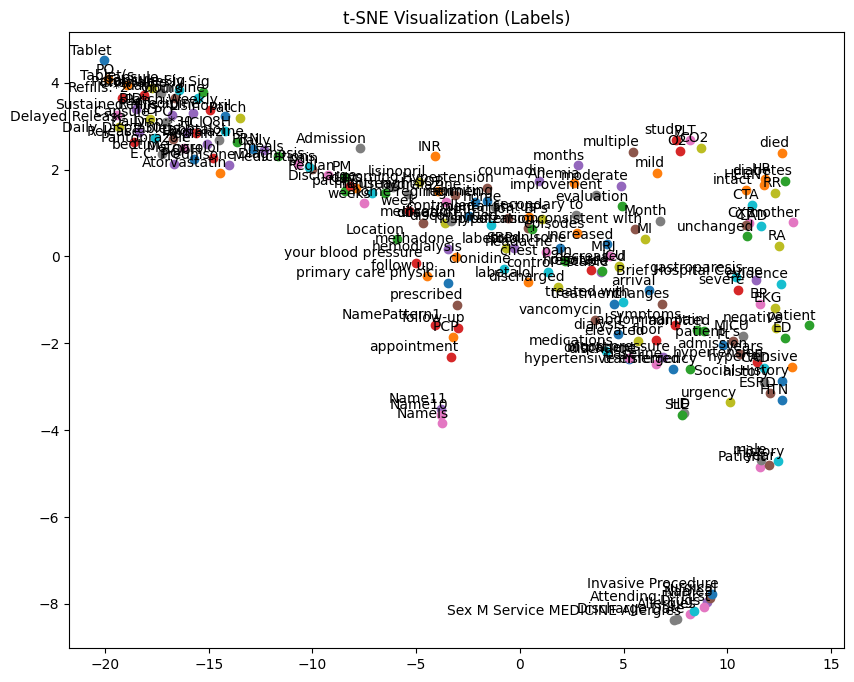

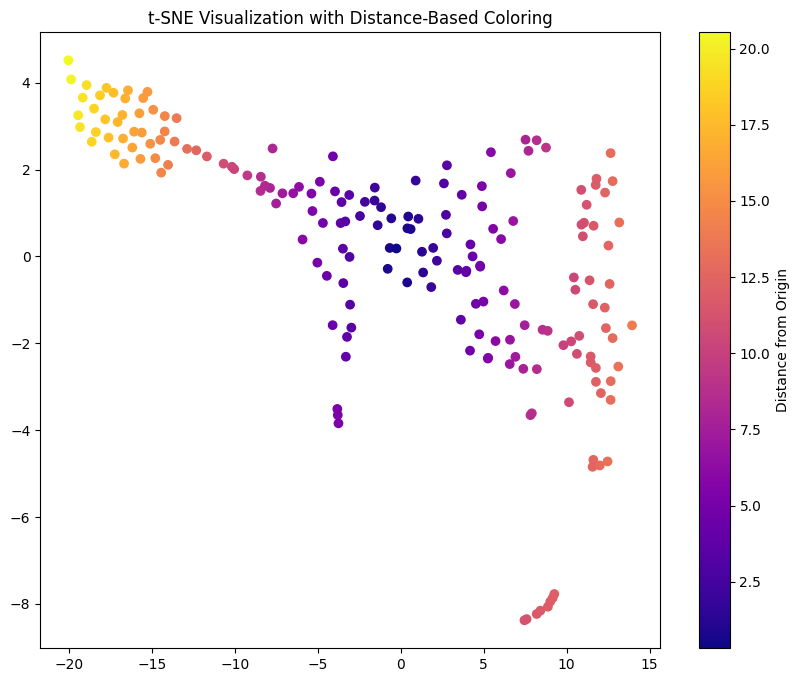

In [ ]:
vocabs = model_word2vec.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(model_word2vec,new_v)

In [ ]:
import gensim
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
print(info)
pretrained_model= api.load("glove-wiki-gigaword-50")
vocabs = pretrained_model.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(pretrained_model,new_v, True)


{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1, 'record_format': 'dict', 'file_size': 6344358, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py', 'license': 'All files released for the task are free for general research use', 'fields': {'2016-train': ['...'], '2016-dev': ['...'], '2017-test': ['...'], '2016-test': ['...']}, 'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.', 'checksum': '701ea67acd82e75f95e1d8e62fb0ad29', 'file_name': 'semeval-2016-2017-task3-subtaskBC.gz',

## Using SciSpacy


In [ ]:
!pip install scispacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 26.6 MB/s eta 0:00:00


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_md-0.5.3.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
  Created wheel for en_core_sci_md: filename=en_core_sci_md-0.5.3-py3-none-any.whl size=119160705 sha256=8a0488472f0facef4ac6849abfe839ad1d9b8d94f2dcdaafbcd9b8e29773dab0
  Stored in directory: /root/.cache/pip/wheels/3f/80/c9/fefe3472be531b02d08ade3509af1a6f62e5ed22dbeb84fefd
Successfully built en_core_sci_md
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
  Attempting uninstall

In [ ]:
import pandas as pd
import scispacy
import spacy

#Load Dischar
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary.csv")

nlp_SciSpaCy = spacy.load('en_core_sci_md')  # Load the specified NLP model

# Apply token extraction
patients_df_SciSpaCy["Processed_Text"] = patients_df_SciSpaCy["TEXT"].apply(lambda text: extract_cleaned_text(text, nlp_SciSpaCy))

#Copy Processed data to google drive
patients_df_SciSpaCy.to_csv(r'Patient_Summary_SciSpacy.csv', index = False)
!cp 'Patient_Summary_SciSpacy.csv' '/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_SciSpacy.csv'

In [ ]:
import pandas as pd
#Load Processed SciSpacy
patients_df_SciSpaCy = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AIH/Patient_Summary_SciSpacy.csv")

In [ ]:
from spacy import displacy
displacy.render(nlp_SciSpaCy( patients_df_SciSpaCy['Processed_Text'][0]), style="ent", jupyter=True)

### Word2Vec and t-SNE Visualization Using SciSpaCy-Processed Data

In [ ]:
from gensim.models import Word2Vec

corpus = build_corpus(patients_df_SciSpaCy, nlp_SciSpaCy)

Minimum word count: 11, Maximum word count: 1152, Median word count: 474


In [ ]:
model_word2vec = Word2Vec(corpus, min_count=50, window=3, vector_size=100)

In [ ]:
model_word2vec.wv.similar_by_key("Clonidine"), model_word2vec.wv.similar_by_key("BP")

([('Patch Weekly', 0.9987740516662598),
  ('Labetalol', 0.9983558058738708),
  ('Patch Weekly Sig', 0.9981586933135986),
  ('Q8H', 0.9978556036949158),
  ('Lisinopril', 0.9977641701698303),
  ('HCl', 0.997312605381012),
  ('Aspirin', 0.9972076416015625),
  ('Patch', 0.9967060089111328),
  ('Q6H', 0.9966330528259277),
  ('Atorvastatin', 0.996251106262207)],
 [('arrival', 0.9982121586799622),
  ('ED', 0.998018741607666),
  ('RA', 0.9977825880050659),
  ('negative', 0.9974157810211182),
  ('hypertension', 0.9971168637275696),
  ('Pt', 0.9968937039375305),
  ('transferred', 0.9968693256378174),
  ('RR', 0.9962092638015747),
  ('Brief Hospital Course', 0.9961373805999756),
  ('years', 0.9957362413406372)])

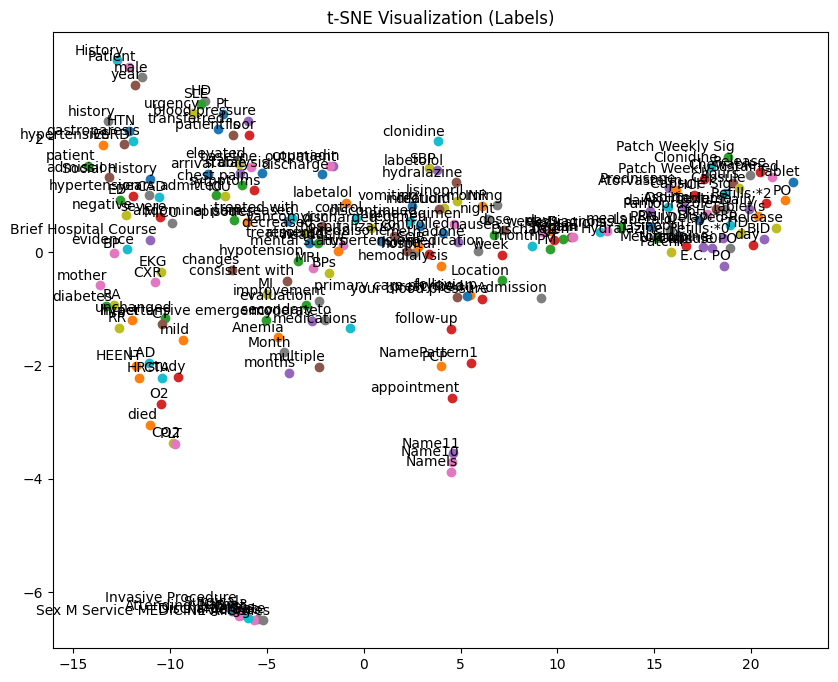

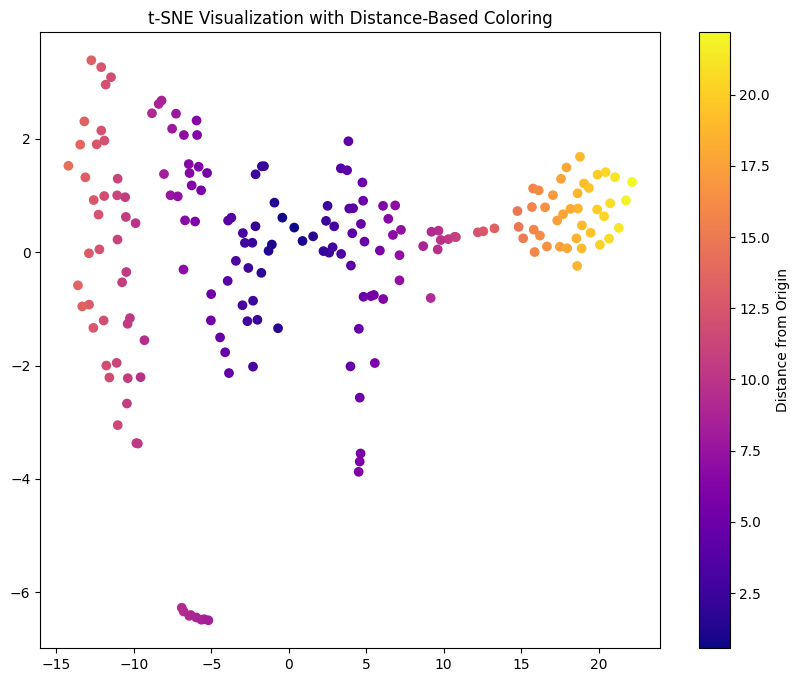

In [ ]:
vocabs = model_word2vec.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(model_word2vec,new_v)


### en_ner_bc5cdr_md Visualization Using SciSpaCy-Processed Data.
  
*   It is a SciSpaCy model, not a standard SpaCy model. It is specifically trained for biomedical named entity recognition (NER), focusing on diseases and chemicals.

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.2/989.2 kB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached thinc-8.0.17-cp311-cp311-linux_x86_64.whl
  Using cached wasabi-0.10.1-py3-none-any.whl.metadata (28 kB)
  Using cached pydantic-1.8.2-py3-none-any.whl.metadata (103 kB)
Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 10.1 MB/s eta 0:00:00
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.4.0-py3-none-any.whl size=125666861 sha256=c9eff27bf4446a8e5874ebd29e7c3e2f680501cf9db90c3dc73ad6ee541d2f3d
  Stored in directory: /root/.cache/pip/wheels/96/37/fc/c6eee4239ccf271541084f54f737f15ed00f62f88406d22471
  Creat

In [ ]:
!pip install -U spacy
!pip install -U pydantic
!pip install scispacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.0.9
    Uninstalling spacy-3.0.9:
      Successfully uninstalled spacy-3.0.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-bc5cdr-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.8.4 which is incompatible.
en-core-sci-md 0.5.3 requires spacy<3.7.0,

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.8.2
    Uninstalling pydantic-1.8.2:
      Successfully uninstalled pydantic-1.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.5 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.8.4 which is incompatible.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.8.4 which is incompatible.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

In [ ]:
import en_ner_bc5cdr_md
import spacy
from spacy import displacy
nlp__bc5cdr = en_ner_bc5cdr_md.load()
displacy.render(nlp__bc5cdr(patients_df_SciSpaCy['Processed_Text'][0]), style="ent", jupyter=True)

### MedSpacy Visualization Using SciSpaCy-Processed Data.

In [ ]:
!pip install medspacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached blis-0.7.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [ ]:
import medspacy
from spacy import displacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent

# Load MedspaCy NLP pipeline
nlp_medspacy = medspacy.load()

# Add rules for target concept extraction
target_matcher = nlp_medspacy.get_pipe("medspacy_target_matcher")
# Define custom rules for better entity detection
target_rules = [
    TargetRule("hyperlipidemia", "DISEASE"),
    TargetRule("O2", "CHEMICAL"),
    TargetRule("FiO2", "CHEMICAL"),
    TargetRule("hypertension", "DISEASE"),
    TargetRule("hypertensive urgency", "DISEASE"),
    TargetRule("obesity", "CONDITION"),
    TargetRule("cardiac", "DISEASE"),
    TargetRule("SLE", "DISEASE"),
    TargetRule("lupus nephritis", "DISEASE"),
    TargetRule("ESRD", "DISEASE"),
    TargetRule("dialysis", "TREATMENT"),
    TargetRule("hemodialysis", "TREATMENT"),
    TargetRule("SBP", "MEASUREMENT"),
    TargetRule("HR", "MEASUREMENT"),
    TargetRule("TPN", "TREATMENT"),
    TargetRule("Prednisone", "MEDICATION"),
    TargetRule("Lisinopril", "MEDICATION"),
    TargetRule("Labetalol", "MEDICATION"),
    TargetRule("Clonidine", "MEDICATION"),
    TargetRule("Valsartan", "MEDICATION"),
    TargetRule("Sevelamer", "MEDICATION"),
    TargetRule("Atropine", "MEDICATION"),
    TargetRule("Morphine sulfate", "MEDICATION"),
    TargetRule("Diarrhea", "SYMPTOM"),
    TargetRule("Headache", "SYMPTOM"),
    TargetRule("nausea", "SYMPTOM"),
    TargetRule("vomiting", "SYMPTOM"),
    TargetRule("shortness of breath", "SYMPTOM"),
    TargetRule("fever", "SYMPTOM"),
    TargetRule("chills", "SYMPTOM")
]

target_matcher.add(target_rules)

# Process the shift note
doc = nlp_medspacy(patients_df_SciSpaCy['Processed_Text'][0])

# visulize
visualize_ent(doc)